In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


cuda


### MNIST Data Generation

In [ ]:
import torch
import numpy as np
import random
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


class MovingMNIST(torch.utils.data.Dataset):
    def __init__(self, num_sequences=1000, sequence_length=20, image_size=32, digit_size=28, speed=2):
        self.mnist = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        self.num_sequences = num_sequences
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.digit_size = digit_size
        self.speed = speed  # pixels/frame

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        canvas_size = self.image_size #32x32 looks similiar as in paper increase if required
        frames = np.zeros((self.sequence_length, canvas_size, canvas_size), dtype=np.float32)

        # Select a random MNIST digit
        #digit_img, _ = self.mnist[random.randint(0, len(self.mnist) - 1)] #Random
        digit_img, label = self.mnist[random.randint(0, len(self.mnist) - 1)]

        # Uncomment the following line to select only a specific digit (e.g., 3) for testing
        while label != 3: digit_img, label = self.mnist[random.randint(0, len(self.mnist) - 1)]

        digit_img = digit_img.squeeze(0).numpy()



        # Random direction: -1 (left) or +1 (right)
        #direction = random.choice([-1, 1]) direction controlled by the training


        direction = 1
        dx = direction * self.speed  # no of pixel left/right

        # Random start
        x = random.randint(0, canvas_size - 1)
        y = random.randint(0, canvas_size - self.digit_size)
        #y = (canvas_size - self.digit_size) // 2  # center vertically if needed

        for t in range(self.sequence_length):
            x_int = int(np.floor(x)) % canvas_size  # wrap x using modulo

            # Handle wrap-around drawing
            if x_int + self.digit_size <= canvas_size:
                # Fully inside canvas
                frames[t, y:y+self.digit_size, x_int:x_int + self.digit_size] += digit_img
            else:
                # Split across right and left border
                right_part = canvas_size - x_int
                left_part = self.digit_size - right_part

                # Right slice
                frames[t, y:y+self.digit_size, x_int:] += digit_img[:, :right_part]
                # Left slice
                frames[t, y:y+self.digit_size, :left_part] += digit_img[:, right_part:]

            x += dx  # move with wrapping

        frames = np.clip(frames, 0, 1)
        frames = torch.tensor(frames).unsqueeze(1)  # shape: (T, 1, H, W)
        return frames


torch.Size([20, 1, 32, 32])


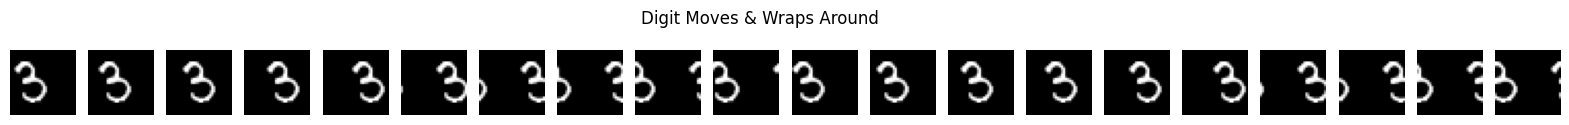

In [4]:
dataset = MovingMNIST(sequence_length=20, speed=3)
sequence = dataset[0]
print(sequence.shape)

def show_sequence(frames, title="Wrapped Digit Movement"):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 1.5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i, 0], cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

show_sequence(sequence, title="Digit Moves & Wraps Around")


In [5]:
# Generate data
X_train = MovingMNIST(num_sequences=2000,sequence_length=20, speed=3)
X_val = MovingMNIST(num_sequences=200, sequence_length=20, speed=3)

# Create data loaders
train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
val_loader = DataLoader(X_val, batch_size=64, shuffle=False)



In [6]:
def time_interval():
    """
    Choose a random t1 in [1,19]
    Choose a random dt between 1 and 4
    Choose random direction +/-1
    Compute t2 = t1 + dt * direction
    Clip t2 to stay within [0,20]
    """
    t1 = random.randint(0, 19)
    dt = random.randint(1, 4)
    direction = random.choice([-1, 1])
    direction = 1  # TODo: Try for both left and right 
    t2 = t1 + dt * direction

    # Border check: clip to [0, 20]
    if t2 < 0:
        t2 = 0
    elif t2 > 19:
        t2 = 19

    return t1, t2, direction







def log_normal_pdf(x, mean, logvar, eps=1e-8): # Added epsilon
    log_two_pi = torch.log(torch.tensor(2. * math.pi, device=x.device, dtype=x.dtype))
    return -0.5 * torch.sum(
        log_two_pi + logvar + ((x - mean) ** 2) / (torch.exp(logvar) + eps), # Added epsilon
        dim=-1
    )

In [7]:
t1, t2, direction = time_interval()
print(t1)
print(t2)
print(direction)

15
16
1


In [8]:
#Sampling example used for loss and testing
for batch in train_loader:
    x = batch
    print(x.shape)
    print(x[:, 13, :,:,:].shape)
    break


torch.Size([64, 20, 1, 32, 32])
torch.Size([64, 1, 32, 32])


In [9]:
#Encoder Class 
import torch
import torch.nn as nn


class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_var):
        eps = torch.randn_like(z_mean)
        return z_mean + eps * torch.exp(0.5 * z_log_var)

class Encoder(nn.Module):
    """
    Input: (B, T, 1, H, W) = (64, 20, 1, 32, 32)
    Output: (B, T, latent_dim) = (64, 20, 15)
    """
    def __init__(self, latent_dim, lstm_hidden_dim=256, num_layers=1, bidirectional=False):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional #Check if bidrectional needed
        self.num_directions = 2 if bidirectional else 1

        # 3D CNN (treats time as depth)
        self.image_encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),   # [B, 1, 20, 32, 32] -> [B, 32, 10, 16, 16]
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # -> [B, 64, 5, 8, 8]
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), # -> [B, 128, 3, 4, 4]
            nn.ReLU(),
            nn.Flatten(),                                           # -> [B, 128*3*4*4] = [B, 6144]
        )

        # Reduce to sequence features (20 timesteps, 32 features each)
        self.fc_bt = nn.Linear(6144, 20 * 32)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Map LSTM output to latent mean and log var
        self.z_mean_t = nn.Linear(self.num_directions * lstm_hidden_dim, latent_dim)
        self.z_log_var_t = nn.Linear(self.num_directions * lstm_hidden_dim, latent_dim)

        self.sampling = Sampling()

    def forward(self, x):  # x: (B, T, 1, 32, 32)
        # CNN expects (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)    # -> (B, 1, T, H, W)
        x = self.image_encoder(x)      # -> (B, 6144)
        x = self.fc_bt(x)              # -> (B, 640)
        bt = x.view(-1, 20, 32)        # -> (B, 20, 32)

        #print("LSTM input shape:", bt.shape)
        # LSTM processing

        lstm_out, _ = self.lstm(bt)    # -> (B, 20, lstm_hidden_dim*num_directions)

        #print("LSTM output shape:", lstm_out.shape)
        # Compute z_mean, z_log_var
        z_mean = self.z_mean_t(lstm_out)      # -> (B, 20, latent_dim)
        z_log_var = self.z_log_var_t(lstm_out)  # -> (B, 20, latent_dim)
        zt = self.sampling(z_mean, z_log_var)  # -> (B, 20, latent_dim)

        return z_mean, z_log_var, zt, bt


In [10]:
class Decoder(nn.Module):
    """
    Input: (B, latent_dim) = (64, 15)
    Output: (B, 1, 32, 32)
    """
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        # Project latent vector to feature map: [B, 128, 4, 4]
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)  # (64, 15) → (64, 2048)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 128, 4, 4) → (64, 64, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (64, 64, 8, 8) → (64, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # (64, 32, 16, 16) → (64, 1, 32, 32)
            nn.Sigmoid()  # constrain output pixel values to [0,1]
        )

    def forward(self, z):
        # z: (64, 15)
        x = self.fc(z)                   # → (64, 2048)
        x = x.view(-1, 128, 4, 4)        # → (64, 128, 4, 4)
        x = self.decoder(x)             # → (64, 1, 32, 32)
        return x

In [11]:
class Decoder_LSTM_CNN(nn.Module):
    """
    Input:  (B, latent_dim)
    Output: (B, 1, 32, 32)
    """
    def __init__(self, latent_dim, lstm_hidden=256):
        super(Decoder_LSTM_CNN, self).__init__()
        self.latent_dim = latent_dim

        # Single LSTM layer
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden, batch_first=True)

        # Normalization + dropout
        self.layer_norm = nn.LayerNorm(lstm_hidden)
        self.dropout = nn.Dropout(0.2)

        # Final projection: map LSTM output to 64*4*4 (CNN input)
        self.fc = nn.Linear(lstm_hidden, 64 * 4 * 4)

        # CNN decoder (lighter)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 4x4 → 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),    # 16x16 → 32x32
            nn.Sigmoid()  # Pixel values in [0,1]
        )

    def forward(self, z):
        # Add sequence dimension: (B, 1, latent_dim)
        z = z.unsqueeze(1)

        # Pass through LSTM
        x, _ = self.lstm(z)  # (B, 1, lstm_hidden)
        x = x[:, -1, :]      # (B, lstm_hidden)

        # Normalize + dropout
        x = self.layer_norm(x)
        x = self.dropout(x)

        # Project to CNN input
        x = self.fc(x)       # (B, 1024)
        x = x.view(-1, 64, 4, 4)

        # Decode to image
        x = self.decoder(x)  # (B, 1, 32, 32)
        return x


In [12]:
class Smoothing(nn.Module):
    def __init__(self, latent_dim,  hidden_dim=128):
        super(Smoothing, self).__init__()

        #input_dim = latent_dim + 32 + 32 + 1  # z_t2 + b_t1 + b_t2 + delta_t
        input_dim = latent_dim + 32 + 32 + 1 + 1 # z_t2 + b_t1 + b_t2 + delta_t + direction

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        ) #Activation function

        self.qs_mean_t1 = nn.Linear(hidden_dim, latent_dim)  # 81 → 15 64x15
        self.qs_log_var_t1 = nn.Linear(hidden_dim, latent_dim)  # 81 → 15 64x15
        #Add activations
        self.sampling = Sampling()

    def forward(self, smoothing_input):
        # smoothing_input shape: (batch, latent_dim + 32 + 32 + 1 + 1 )
        h = self.mlp(smoothing_input)
        qs_mean = self.qs_mean_t1(h)      # (batch, latent_dim)  # (64, 15)
        qs_log_var = self.qs_log_var_t1(h)  # (64, 15)
        qs_log_var = torch.clamp(qs_log_var, min=-10.0, max=10.0) # Clip log var for stability

        zt1 = self.sampling(qs_mean, qs_log_var)        # (batch, latent_dim)  # (64, 15)

        return zt1, qs_mean, qs_log_var #all have shape = (latent_dim)

In [13]:
import torch
import torch.nn as nn

class Transition(nn.Module):
    def __init__(self, latent_dim, hidden_dim =128):
        super(Transition, self).__init__()
        #input_dim = latent_dim + 1  # z_t1 + delta_t
        input_dim = latent_dim + 1 + 1 # z_t1 + delta_t + direction


        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pt_mean_t1 = nn.Linear(input_dim, latent_dim)
        self.pt_log_var_t1 = nn.Linear(input_dim, latent_dim)
        #Add activations

    def forward(self, transition_input):
        # transition_input shape: (batch, latent_dim + 1 + 1)

        transition_output = self.mlp(transition_input)
        pt_mean = self.pt_mean_t1(transition_input)      # (batch, latent_dim)
        pt_log_var = self.pt_log_var_t1(transition_input)
        pt_log_var = torch.clamp(pt_log_var, min=-10.0, max=10.0) # Clip log var for stability

        return pt_mean, pt_log_var

In [14]:
latent_dim = 15

In [15]:
## checking dimensions of the encoder Smoothing transition and Decoder

# Instantiate the model
encoder = Encoder(latent_dim=latent_dim).to(device)

# Set model to eval mode (optional for testing)
encoder.eval()

# Get one batch from the DataLoader
for batch in train_loader:
    x = batch.to(device)  # shape: [64, 20, 1, 32, 32]
    print("Input data shape:", x.shape)
    # Forward pass through encoder
    with torch.no_grad():  # disable gradient computation for testing
        z_mean, z_log_var, zt, bt = encoder(x)

    print("z_mean shape:", z_mean.shape)       # Expected: [64, 20, 15]
    print("z_log_var shape:", z_log_var.shape) # Expected: [64, 20, 15]
    print("zt shape:", zt.shape)               # Expected: [64, 20, 15]
    print("bt shape:", bt.shape)               # Expected: [64, 20, 32]

    smoothing = Smoothing(latent_dim=latent_dim).to(device)

    t1, t2, direction = time_interval()
    print("t1:", t1)
    print("t2:", t2)
    print("direction:", direction)
    bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each


    print("bt1 shape:", bt1.shape)
    print("bt2 shape:", bt2.shape)
    zt2 = zt[:, t2, :] #(64,15)

    print("zt2 shape:", zt2.shape)

    # dt as scalar difference
    dt_value = abs(t2 - t1)

    # Create as tensor on the same device
    dt = torch.full((bt1.shape[0], 1), dt_value, device=device, dtype=torch.float32)
    direction = torch.full((bt1.shape[0], 1), 1.0 if t2 > t1 else -1.0, device=device, dtype=torch.float32)

    # Concatenate
    smoothing_inputs = torch.cat((bt1, bt2, zt2, dt, direction), dim=-1)
    print("smoothing_inputs shape:", smoothing_inputs.shape)

    zt1, qs_mean, qs_log_var = smoothing(smoothing_inputs)
    print("zt1 shape:", zt1.shape)
    print("qs_mean shape:", qs_mean.shape)
    print("qs_log_var shape:", qs_log_var.shape)

    transition = Transition(latent_dim=latent_dim).to(device)

    trans_input = torch.cat((zt1, dt, direction), dim=-1) #(64, 15 + 1 + 1) = (64, 17)
    print("trans_input shape:", trans_input.shape)
    pt_mean, pt_log_var = transition(trans_input) #(64 x 15) each

    print("pt_mean shape:", pt_mean.shape)
    print("pt_log_var shape:", pt_log_var.shape)

    decoder_input = zt[:,15,:]
    print("decoder_input shape:", decoder_input.shape)
    #decoder = Decoder(latent_dim=latent_dim).to(device)
    decoder = Decoder_LSTM_CNN(latent_dim=latent_dim).to(device)
    #decoder = Decoder_LSTM_3DCNN(latent_dim=latent_dim).to(device)

    reconstruction = decoder(decoder_input)
    print("reconstruction shape:", reconstruction.shape)


    #Sampling the data

    sample_x = x[:,15,:,:,:]
    print("sample_x shape:", sample_x.shape)
    break  # just one batch


Input data shape: torch.Size([64, 20, 1, 32, 32])
z_mean shape: torch.Size([64, 20, 15])
z_log_var shape: torch.Size([64, 20, 15])
zt shape: torch.Size([64, 20, 15])
bt shape: torch.Size([64, 20, 32])
t1: 2
t2: 3
direction: 1
bt1 shape: torch.Size([64, 32])
bt2 shape: torch.Size([64, 32])
zt2 shape: torch.Size([64, 15])
smoothing_inputs shape: torch.Size([64, 81])
zt1 shape: torch.Size([64, 15])
qs_mean shape: torch.Size([64, 15])
qs_log_var shape: torch.Size([64, 15])
trans_input shape: torch.Size([64, 17])
pt_mean shape: torch.Size([64, 15])
pt_log_var shape: torch.Size([64, 15])
decoder_input shape: torch.Size([64, 15])
reconstruction shape: torch.Size([64, 1, 32, 32])
sample_x shape: torch.Size([64, 1, 32, 32])


In [16]:
def direction_of_time_interval(t1, t2):
    if t2 > t1:
        direction = 1
    else:
        direction = -1

    t2 = t1 + direction
    return t2

In [ ]:
def linear_beta_schedule(epoch, max_epochs, max_beta=1.0, min_beta=0.0):
    return min_beta + (max_beta - min_beta) * (epoch / max_epochs)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random

class VAE(nn.Module):
    def __init__(self, encoder, decoder, smoothing, transition, latent_dim, transition_matrix_A, prior_covariance, Markov_Prior=0):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.smoothing = smoothing
        self.transition = transition
        self.Markov_Prior = Markov_Prior

        self.A = transition_matrix_A  # shape: (latent_dim, latent_dim)
        self.cov = prior_covariance   # shape: (latent_dim,) or (latent_dim, Alatent_dim)

        # You can track losses using simple Python variables in your training loop
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    def reset_loss_trackers(self):
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data, optimizer, beta, device):

      data = data.to(device)
      # print(f"Data shape: {data.shape}, dtype: {data.dtype}") # Debug print


      if self.Markov_Prior == 1:
          # === Markov Prior ===
          z_mean, z_log_var, z, bt = self.encoder(data)

          t1, t2, direction = time_interval()
          # Ensure t1 and t2 are within valid range
          T = data.shape[1]
          t1 = max(0, min(t1, T - 1))
          t2 = max(0, min(t2, T - 1))


          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)
          dt = (t2 - t1) * torch.ones((bt1.shape[0], 1), device=device) #(64,1)
          direction_tensor = torch.full((data.size(0), 1), fill_value=direction, dtype=dt.dtype, device=device) #(64,1)


          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt, direction_tensor), dim=-1) # (64, 80) → (64, 15)
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs) #(64,15) each


          #A_pow = self.A.to(device) ** (t2 - t1)
          A_pow = torch.matrix_power(self.A, t2 - t1)
          pt_mean = zt1 @ A_pow.T   # (64, 15) @ (15, 15).T → (64, 15) Matrix multiplication
          pt_log_var = torch.log(self.cov) * A_poly(self.A, t2 - t1 - 1)

      else:
          # === Non-Markov ===
          z_mean, z_log_var, z, bt = self.encoder(data) #64x20x1x32x32 - 64x20x15

          #For debugging
          # print(f"z_mean shape: {z_mean.shape}, z_log_var shape: {z_log_var.shape}, z shape: {z.shape}, bt shape: {bt.shape}")

          t1, t2, direction = time_interval()

          #t2 = direction_of_time_interval(t1, t2)
          
          # Ensure t1 and t2 are within valid range
          T = data.shape[1]
          t1 = max(0, min(t1, T - 1))
          t2 = max(0, min(t2, T - 1))
          
          # print(f"Selected t1: {t1}, t2: {t2}, direction: {direction}") For debugging
          
          #Sample belief state from t1 and t2 and latent at t2
          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)

          dt = torch.full((data.size(0), 1), t2 - t1, dtype=bt1.dtype, device=data.device) #(64,1)
          direction_tensor = torch.full((data.size(0), 1), fill_value=direction, dtype=dt.dtype, device=device)


          # print(f"bt1 shape: {bt1.shape}, bt2 shape: {bt2.shape}, zt2 shape: {zt2.shape}, dt shape: {dt.shape}, direction shape: {direction_tensor.shape}") For debugging


          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt, direction_tensor), dim=-1)   #(64,81)
          # print(f"Smoothing inputs shape: {smoothing_inputs.shape}")
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs)  #(64,15) each
          # print(f"zt1 shape: {zt1.shape}, qs_mean shape: {qs_mean.shape}, qs_log_var shape: {qs_log_var.shape}")


          trans_input = torch.cat((zt1, dt, direction_tensor), dim=-1) #(64, 15 + 1 + 1) = (64, 17)
          # print(f"Transition input shape: {trans_input.shape}")
          pt_mean, pt_log_var = self.transition(trans_input) #(64 x 15) each
          # print(f"pt_mean shape: {pt_mean.shape}, pt_log_var shape: {pt_log_var.shape}")


      # === Decoder ===
      reconstruction = self.decoder(zt2) #(64,15) - (64,1,32,32)
      target = data[:, t2, :] #(64,1,32,32)
      
      # --- Flatten for BCE ---
      batch_size = reconstruction.size(0)
      reconstruction = reconstruction.view(batch_size, -1)  # (64, 1024) for MNIST-like
      target = target.view(batch_size, -1)                  # (64, 1024)

      # Print min/max values for debugging 
      #print(f"Reconstruction min: {reconstruction.min().item()}, max: {reconstruction.max().item()}") 
      #print(f"Target min: {target.min().item()}, max: {target.max().item()}")


      # === Reconstruction Loss (Binary Cross Entropy) ===
      bce = F.binary_cross_entropy(reconstruction, target, reduction='sum') / (batch_size) #SCaing the loss add normalisa
      

      # -------------------------------------------------------------------------
      # === KL Divergence Terms (Stable VAE formula) ===
      # KL[q(z1|z2,b1) || p(z1)]  ~ smoothing posterior vs standard normal prior
      # -------------------------------------------------------------------------
      mu_zt1, logvar_zt1 = qs_mean, qs_log_var
      kl_smoothing_prior = -0.5 *torch.sum(
          1 + logvar_zt1 - mu_zt1.pow(2) - logvar_zt1.exp(),
          dim=1
      ).mean()
       

      # -------------------------------------------------------------------------
      # KL[q(z2|b2) || p(z2|z1)]  ~ posterior vs transition prior
      # -------------------------------------------------------------------------
      mu_post, logvar_post = z_mean[:, t2, :], z_log_var[:, t2, :]
      mu_prior, logvar_prior = pt_mean, pt_log_var

      kl_posterior_transition = 0.5 * torch.sum(
          logvar_prior - logvar_post
          + (logvar_post.exp() + (mu_post - mu_prior).pow(2)) / logvar_prior.exp()
          - 1,
          dim=1
      ).mean()

      #Total Kl
      total_kl = kl_smoothing_prior + kl_posterior_transition

      #Total Loss
      total_loss = bce + beta*total_kl
      
      #Backward pass and optimization
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      # metrics
      return {
          'loss': total_loss.item(),
          'reconstruction_loss': bce.item(),
          'kl_smoothing_prior': kl_smoothing_prior.item(),
          'kl_posterior_transition': kl_posterior_transition.item()
          }

In [19]:
# Instances of the network classes

encoder = Encoder(latent_dim)

decoder = Decoder_LSTM_CNN(latent_dim)
#decoder = Decoder(latent_dim)

smoothing = Smoothing(latent_dim)
transition = Transition(latent_dim)


In [20]:
latent_dim = 215

In [21]:
A_diag = torch.eye(15, dtype=torch.float32, device=device)  # or torch.rand(3, 3)
cov = torch.ones(15, dtype=torch.float32, device=device)    # or torch.eye(3)

In [22]:
# Testing the Network
import math

beta = 0
initial_lr =  5e-4

vae = VAE(encoder, decoder, smoothing, transition, latent_dim=latent_dim, transition_matrix_A=A_diag, prior_covariance=torch.ones(latent_dim), Markov_Prior=0)       # construct the model
vae.to(device)        # move to GPU/CPU
vae.train()           # <- do not remove or redefine this!
vae.reset_loss_trackers()

optimizer = torch.optim.Adam(vae.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

for batch in train_loader:
    x = batch.to(device)
    
    metrics = vae.train_step(x, optimizer, beta, device)
    print(metrics)
    print(x.shape)
    break
#if no error the dimensions are okay; use print above to check for nans     

{'loss': 693.7862548828125, 'reconstruction_loss': 693.7862548828125, 'kl_smoothing_prior': 0.04170079156756401, 'kl_posterior_transition': 3.790931224822998}
torch.Size([64, 20, 1, 32, 32])


In [23]:
num_epochs = 50 # Increased to 1000
vae.train() 

# Initialize lists to store losses for plotting
loss_history = []
bce_history = []
kl_smooth_history = []
kl_post_history = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_bce = 0.0
    total_kl_smooth = 0.0
    total_kl_post = 0.0
    num_batches = 0

    for batch in train_loader:
        x = batch.to(device)  # Move input to device
        beta = linear_beta_schedule(epoch, num_epochs)
        # Train step returns updated metrics
        metrics = vae.train_step(x, optimizer, beta, device)

        total_loss += metrics['loss']
        total_bce += metrics['reconstruction_loss']
        total_kl_smooth += metrics['kl_smoothing_prior']
        total_kl_post += metrics['kl_posterior_transition']
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_bce = total_bce / num_batches
    avg_kl_smooth = total_kl_smooth / num_batches
    avg_kl_post = total_kl_post / num_batches

    # Save average losses to history lists
    loss_history.append(avg_loss)
    bce_history.append(avg_bce)
    kl_smooth_history.append(avg_kl_smooth)
    kl_post_history.append(avg_kl_post)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Beta {beta:.4f} | "
          f"Loss: {avg_loss:.4f} | "
          f"Recon BCE: {avg_bce:.4f} | "
          f"KL Smooth: {avg_kl_smooth:.4f} | "
          f"KL Post: {avg_kl_post:.4f}")

    # Step the scheduler at the end of the epoch
    scheduler.step()
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

# Save model weights
torch.save(vae.state_dict(), "vae_weights.pth")

# Save training history
history = {
    "loss": loss_history,
    "bce": bce_history,
    "kl_smooth": kl_smooth_history,
    "kl_post": kl_post_history
}



torch.save(history, "training_history.pth")

print("Training complete. Model weights and history saved.")


Epoch 1/50 | Beta 0.0000 | Loss: 554.6977 | Recon BCE: 554.6977 | KL Smooth: 27.2933 | KL Post: 202.0862
Current LR: 0.000500
Epoch 2/50 | Beta 0.0200 | Loss: 345.2321 | Recon BCE: 344.5246 | KL Smooth: 4.0859 | KL Post: 31.2859
Current LR: 0.000500
Epoch 3/50 | Beta 0.0400 | Loss: 319.9567 | Recon BCE: 319.3177 | KL Smooth: 1.5082 | KL Post: 14.4680
Current LR: 0.000500
Epoch 4/50 | Beta 0.0600 | Loss: 316.0299 | Recon BCE: 315.3471 | KL Smooth: 1.6405 | KL Post: 9.7401
Current LR: 0.000500
Epoch 5/50 | Beta 0.0800 | Loss: 312.7953 | Recon BCE: 312.1719 | KL Smooth: 1.2493 | KL Post: 6.5433
Current LR: 0.000500
Epoch 6/50 | Beta 0.1000 | Loss: 304.2110 | Recon BCE: 303.3016 | KL Smooth: 1.1804 | KL Post: 7.9136
Current LR: 0.000500
Epoch 7/50 | Beta 0.1200 | Loss: 240.7605 | Recon BCE: 238.2855 | KL Smooth: 1.6163 | KL Post: 19.0084
Current LR: 0.000500
Epoch 8/50 | Beta 0.1400 | Loss: 228.3380 | Recon BCE: 225.5384 | KL Smooth: 2.0955 | KL Post: 17.9022
Current LR: 0.000500
Epoch 9/5

C:\Users\jayan\AppData\Local\Temp\ipykernel_47564\1608144435.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load("training_history.pth")


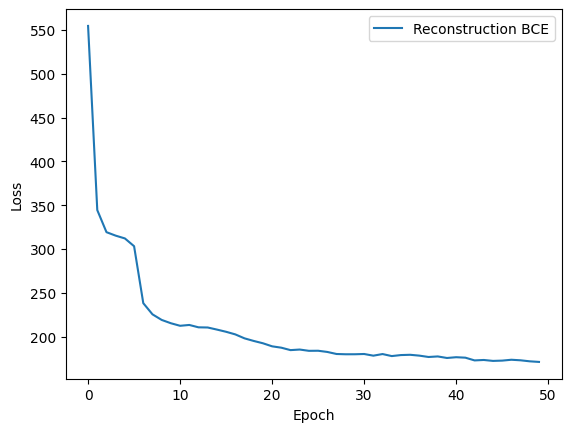

In [32]:
import torch
import matplotlib.pyplot as plt

history = torch.load("training_history.pth")

#plt.plot(history["loss"], label="Total Loss")
plt.plot(history["bce"], label="Reconstruction BCE")
#plt.plot(history["kl_smooth"], label="KL Smooth")
#plt.plot(history["kl_post"], label="KL Post")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
def sample_gaussian(z_mean, z_log_var):
    
    epsilon = torch.randn_like(z_mean)  
    std = torch.exp(0.5 * z_log_var)  
    return z_mean + std * epsilon

In [ ]:

batch_size = 16
sequence_length = 20
image_size = 32
num_samples = 64
direction = 1

# Test DataLoader
X_test = MovingMNIST(num_samples, sequence_length=sequence_length, speed=3)
#X_test = MovingMNISTDataset(data_path, num_sequences=num_samples, seq_len=20, digit=1)

test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

# Get a batch of test sequences
x_test_batch = next(iter(test_loader))  # shape: (B, T, 1, 32, 32)
x_test_batch = x_test_batch.to(device)
print(f"Input batch shape: {x_test_batch.shape}")  # torch.Size([16, 20, 1, 32, 32])

# Forward pass through encoder
t1 = 6
z_mean, z_log_var, z, bt = encoder(x_test_batch) # z shape = (1,20,latent dim)
print("z shape:", z.shape )
zt1 = z[:,t1,:] #(num_samples,latent dim)
print("zt1 shape:", zt1.shape)

for dt in range(1,5):
  #print("dt:", dt)
  t2 = t1 + direction*dt
  #print("t2:", t2)
  dt_tensor = torch.full((batch_size, 1), fill_value=dt, dtype=zt1.dtype, device=device)
  direction_tensor = torch.full((batch_size, 1), fill_value=direction, dtype=zt1.dtype, device=device)
  #print("dt_tensor:", dt_tensor)

  print("dt_tensor shape:", dt_tensor.shape)
  print("direction_tensor shape:", direction_tensor.shape)

  transition_input = torch.cat([zt1, dt_tensor, direction_tensor], dim=-1)
  print("transition_input shape:", transition_input
        .shape)
  pt_mean, pt_log_var = transition(transition_input)

  print("pt_mean shape:", pt_mean.shape)
  print("pt_log_var shape:", pt_log_var.shape)

  zt2 = sample_gaussian(pt_mean, pt_log_var)
  print("zt2 shape:", zt2.shape)
  xt2 = decoder(zt2)
  print("xt2 shape:", xt2.shape)

Input batch shape: torch.Size([16, 20, 1, 32, 32])
z shape: torch.Size([16, 20, 15])
zt1 shape: torch.Size([16, 15])
dt_tensor shape: torch.Size([16, 1])
direction_tensor shape: torch.Size([16, 1])
transition_input shape: torch.Size([16, 17])
pt_mean shape: torch.Size([16, 15])
pt_log_var shape: torch.Size([16, 15])
zt2 shape: torch.Size([16, 15])
xt2 shape: torch.Size([16, 1, 32, 32])
dt_tensor shape: torch.Size([16, 1])
direction_tensor shape: torch.Size([16, 1])
transition_input shape: torch.Size([16, 17])
pt_mean shape: torch.Size([16, 15])
pt_log_var shape: torch.Size([16, 15])
zt2 shape: torch.Size([16, 15])
xt2 shape: torch.Size([16, 1, 32, 32])
dt_tensor shape: torch.Size([16, 1])
direction_tensor shape: torch.Size([16, 1])
transition_input shape: torch.Size([16, 17])
pt_mean shape: torch.Size([16, 15])
pt_log_var shape: torch.Size([16, 15])
zt2 shape: torch.Size([16, 15])
xt2 shape: torch.Size([16, 1, 32, 32])
dt_tensor shape: torch.Size([16, 1])
direction_tensor shape: torch.

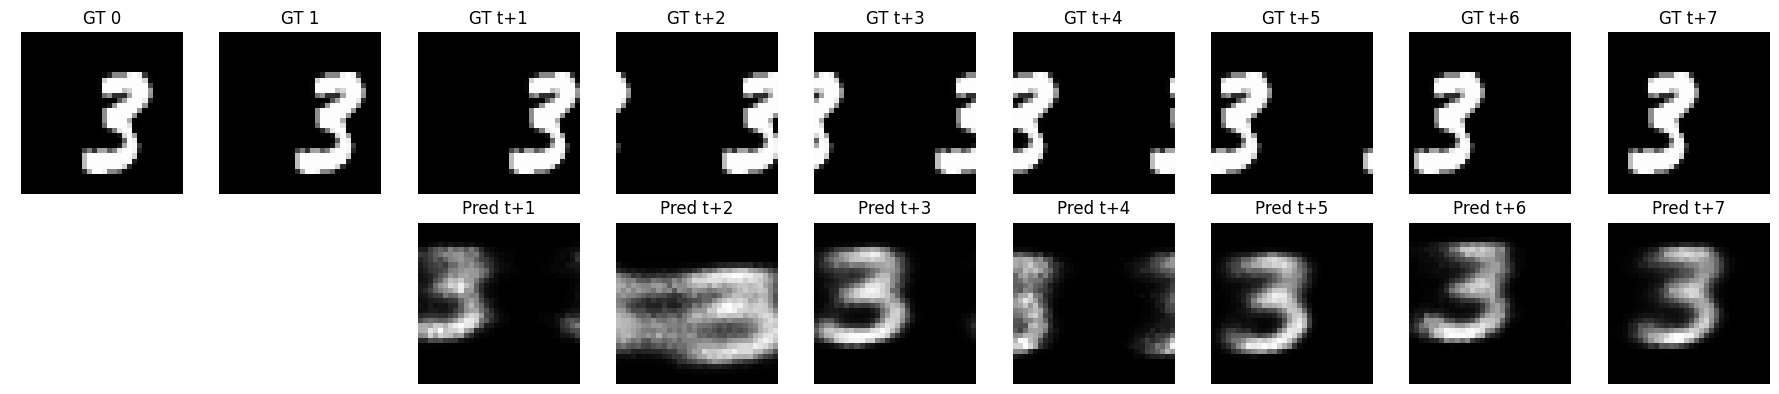

In [ ]:
import matplotlib.pyplot as plt
import torch 

t1 = 2
t_end = 8


def to_numpy(img_tensor):
    return img_tensor.detach().cpu().numpy()

def plot_predictions_with_gt(x_test_batch, t1, xt2_list):
    batch_idx = 0  # visualize first sequence
    num_future = len(xt2_list)
    total_cols = t1 + num_future

    fig, axes = plt.subplots(2, total_cols, figsize=(2*total_cols, 4))

    for i in range(total_cols):
        if i < t1:
            axes[0, i].imshow(to_numpy(x_test_batch[batch_idx, i, 0]), cmap='gray')
            axes[0, i].set_title(f"GT {i}")
        else:
            axes[0, i].imshow(to_numpy(x_test_batch[batch_idx, i, 0]), cmap='gray')
            axes[0, i].set_title(f"GT t+{i - t1 + 1}")
        axes[0, i].axis('off')

    for j, pred_frame in enumerate(xt2_list):
        col_idx = t1 + j
        axes[1, col_idx].imshow(to_numpy(pred_frame[batch_idx, 0]), cmap='gray')
        axes[1, col_idx].set_title(f"Pred t+{j+1}")
        axes[1, col_idx].axis('off')

    for i in range(t1):
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

xt2_list = []
for dt in range(1, t_end):
    t2 = t1 + dt
    dt_tensor = torch.full((batch_size, 1), fill_value=dt, dtype=zt1.dtype, device=device)
    direction_tensor = torch.full((batch_size, 1), fill_value=direction, dtype=zt1.dtype, device=device)
    transition_input = torch.cat([zt1, dt_tensor, direction_tensor], dim=-1)
    pt_mean, pt_log_var = transition(transition_input)
    zt2 = sample_gaussian(pt_mean, pt_log_var)
    xt2 = decoder(zt2)  # shape: [B, 1, 32, 32]
    xt2_list.append(xt2)

#Plot Ground truth vs Predicted
plot_predictions_with_gt(x_test_batch, t1, xt2_list)


In [ ]:
#Sample next sample from generated sample keeping dt=1 everywhere

# x_test_batch: (B, T, 1, 32, 32)

t1 = 5
z_mean, z_log_var, z, _ = encoder(x_test_batch)  # (B, T, latent_dim)
zt = z[:, t1, :]  # starting/initial latent

predictions = []  # store predicted frames

num_future_steps = 8
direction = 1

for step in range(num_future_steps):
    dt = 1  #Next step
    dt_tensor = torch.full((batch_size, 1), dt, dtype=zt.dtype, device=device)
    direction_tensor = torch.full((batch_size, 1), direction, dtype=zt.dtype, device=device)

    # Transition step
    transition_input = torch.cat([zt, dt_tensor, direction_tensor], dim=-1)
    pt_mean, pt_log_var = transition(transition_input)
    zt = sample_gaussian(pt_mean, pt_log_var)  # this becomes next input

    # Decode
    xt = decoder(zt)
    predictions.append(xt)

# predictions is a list of tensors, each (B, 1, 32, 32)
predictions = torch.stack(predictions, dim=1)  # (B, num_future_steps, 1, 32, 32)


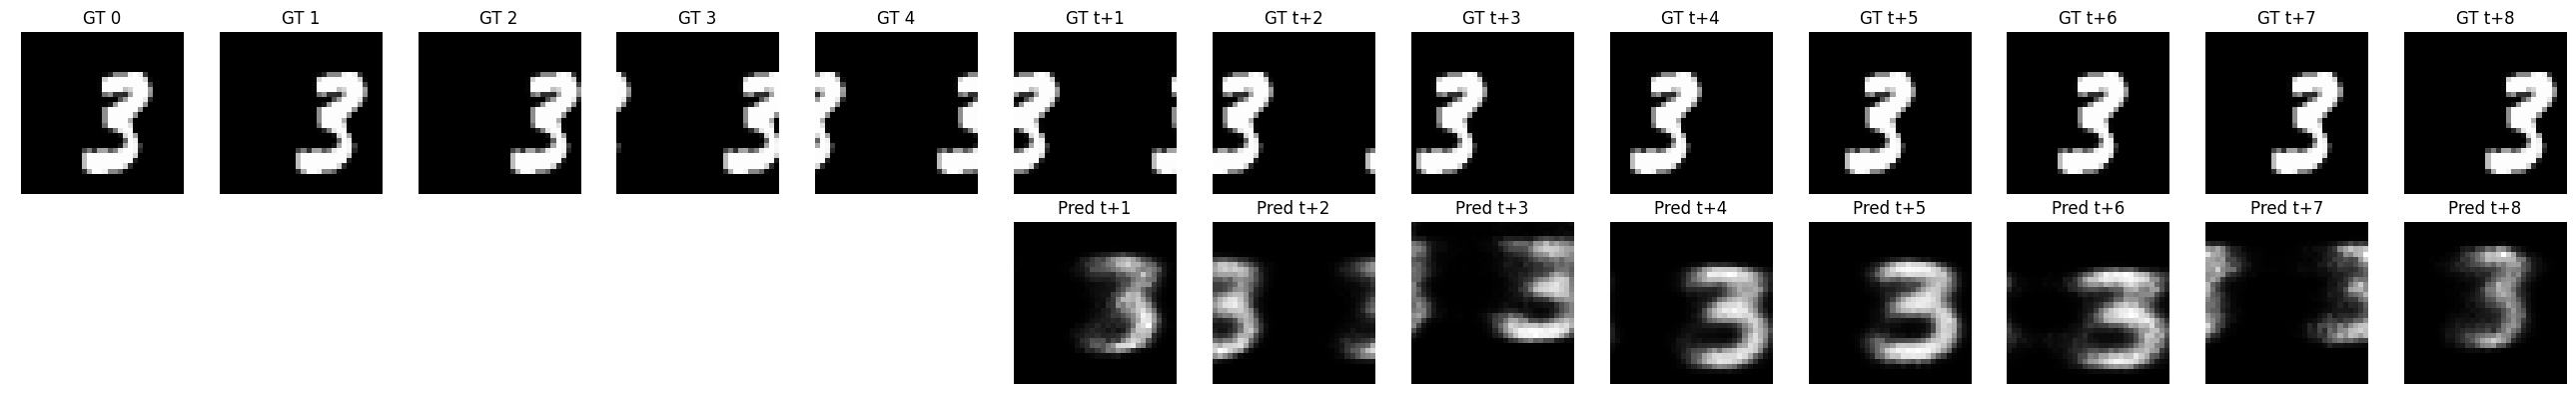

: 

In [ ]:
import matplotlib.pyplot as plt

t1 = 2      # starting time step
num_future = 8   # number of future predictions

def to_numpy(img_tensor):
    return img_tensor.detach().cpu().numpy()

def autoregressive_predict(x_test_batch, t1, num_future, direction=1):
    
    # EncodeR 
    z_mean, z_log_var, z, _ = encoder(x_test_batch)  # (B, T, latent_dim)
    zt = z[:, t1, :]  # starting latent

    xt2_list = []

    for _ in range(num_future):
        dt = 1  # next step in each prediction

        dt_tensor = torch.full((batch_size, 1), dt, dtype=zt.dtype, device=device)
        direction_tensor = torch.full((batch_size, 1), direction, dtype=zt.dtype, device=device)

        # Transition
        transition_input = torch.cat([zt, dt_tensor, direction_tensor], dim=1)
        pt_mean, pt_log_var = transition(transition_input)
        zt = sample_gaussian(pt_mean, pt_log_var)  # feed forward next step

        # Decode predicted latent to image
        xt = decoder(zt)  # shape: (B, 1, 32, 32)
        xt2_list.append(xt)

    return xt2_list

# Plotiing
def plot_predictions_with_gt(x_test_batch, t1, xt2_list):
    batch_idx = 0  # visualize first sequence
    num_future = len(xt2_list)
    total_cols = t1 + num_future

    fig, axes = plt.subplots(2, total_cols, figsize=(2*total_cols, 4))

    # Ground truth
    for i in range(total_cols):
        axes[0, i].imshow(to_numpy(x_test_batch[batch_idx, i, 0]), cmap='gray')
        axes[0, i].set_title(f"GT {i}" if i < t1 else f"GT t+{i-t1+1}")
        axes[0, i].axis('off')

    # Predictions
    for j, pred_frame in enumerate(xt2_list):
        col_idx = t1 + j
        axes[1, col_idx].imshow(to_numpy(pred_frame[batch_idx, 0]), cmap='gray')
        axes[1, col_idx].set_title(f"Pred t+{j+1}")
        axes[1, col_idx].axis('off')

    for i in range(t1):
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# ---- Run autoregressive predictions and plot ----
xt2_list = autoregressive_predict(x_test_batch, t1=t1, num_future=num_future, direction=1)
plot_predictions_with_gt(x_test_batch, t1, xt2_list)
